# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Read The Data

In [2]:
df=pd.read_excel("../input/customer-segmentation-dataset/Online Retail.xlsx")

In [3]:
print(f'This data has {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

This data has 541909 rows and 8 columns.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#Statistical Informations
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


In [6]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
#Feature Engineering
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Year']=df['InvoiceDate'].dt.year
df['Month']=df['InvoiceDate'].dt.month
df['Day']=df['InvoiceDate'].dt.day

df['Totalcost']=df['Quantity']*df['UnitPrice']

In [8]:
#Drop needless columns and Wrong data
df.drop(['InvoiceNo','StockCode','InvoiceDate','CustomerID'],axis=1,inplace=True) 

wrong_values=df[df['Quantity']<0].index
df.drop(index=wrong_values,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)
df

,Description,Quantity,UnitPrice,Country,Year,Month,Day,Totalcost
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010,12,1,15.30
1,WHITE METAL LANTERN,6,3.39,United Kingdom,2010,12,1,20.34
2,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010,12,1,22.00
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010,12,1,20.34
4,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010,12,1,20.34
...,...,...,...,...,...,...,...,...
531280,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,2011,12,9,10.20
531281,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,2011,12,9,12.60
531282,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,2011,12,9,16.60
531283,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,2011,12,9,16.60


In [9]:
#Check missing values
df.isnull().sum()

Description    592
Quantity         0
UnitPrice        0
Country          0
Year             0
Month            0
Day              0
Totalcost        0
dtype: int64

In [10]:
#Drop missing values
df.dropna(subset=['Description'],inplace=True)

In [11]:
#Check Duplication
df.duplicated().sum()

71172

In [12]:
#Drop Duplicates
df.drop_duplicates(inplace=True)

In [13]:
#Free Palestine
df['Country']=df['Country'].replace('Israel','Palestine')

- **Check and Handle Outliers**

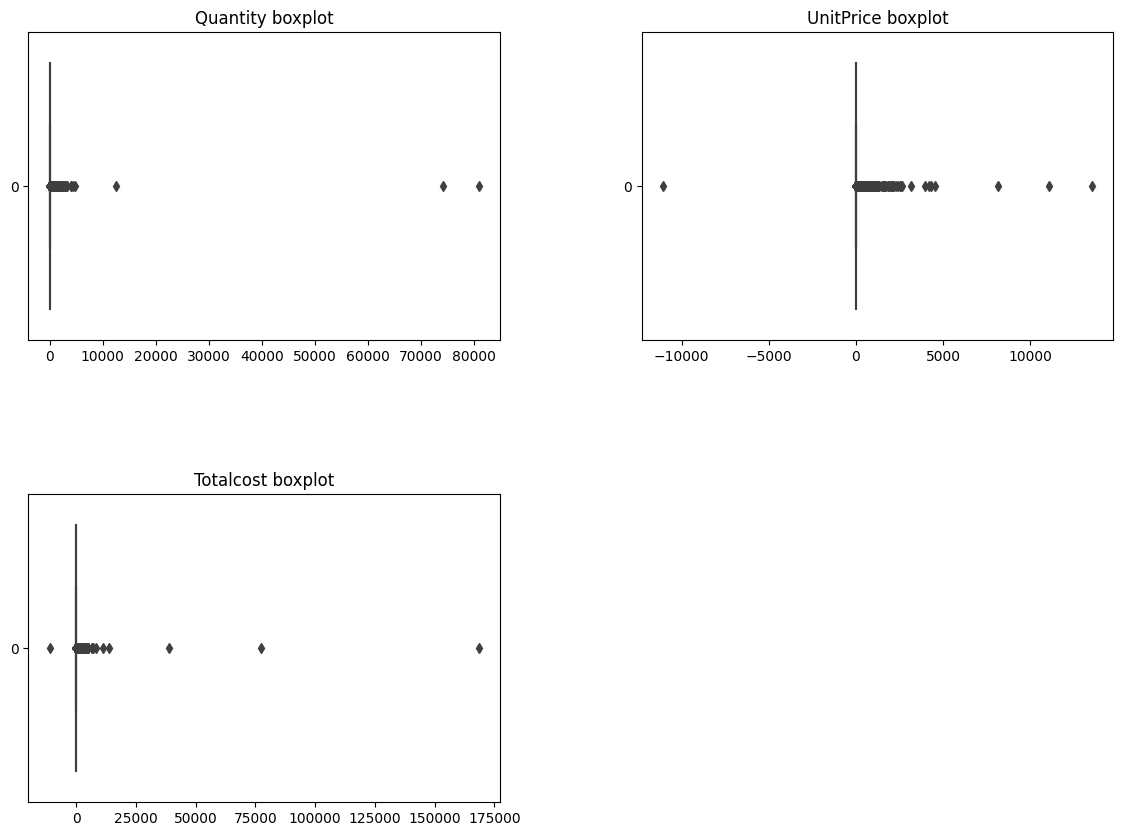

In [14]:
outliers=['Quantity','UnitPrice','Totalcost']
plt.figure(figsize=(14, 10))
for i, col in enumerate(outliers):
    plt.subplot(2, 2, i+1)
    sns.boxplot(df[col], orient="h")
    plt.title(f"{col} boxplot")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [15]:
for col in outliers:
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - 1.5 * IQR
    Upper_Fence = Q3 + 1.5 * IQR
    Lower_Outliers = df[df[col] < Lower_Fence][col].values
    Upper_Outliers = df[df[col] > Upper_Fence][col].values
    df[col].replace(Lower_Outliers, Lower_Fence, inplace=True)
    df[col].replace(Upper_Outliers, Upper_Fence, inplace=True)

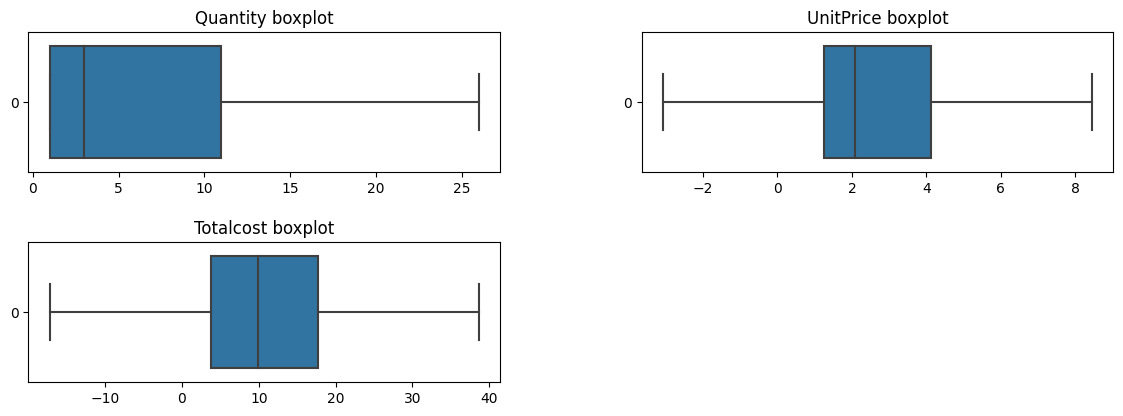

In [16]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(outliers):
    plt.subplot(4, 2, i+1)
    sns.boxplot(df[col], orient="h")
    plt.title(f"{col} boxplot")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [17]:
corr=df.corr(numeric_only=True)
corr

,Quantity,UnitPrice,Year,Month,Day,Totalcost
Quantity,1.000000,-0.360172,0.032793,-0.010834,0.003755,0.614235
UnitPrice,-0.360172,1.000000,-0.042501,-0.009203,0.000291,0.291265
Year,0.032793,-0.042501,1.000000,-0.368850,0.159218,0.002300
Month,-0.010834,-0.009203,-0.368850,1.000000,-0.115379,-0.013091
Day,0.003755,0.000291,0.159218,-0.115379,1.000000,0.001450
Totalcost,0.614235,0.291265,0.002300,-0.013091,0.001450,1.000000


<Axes: >

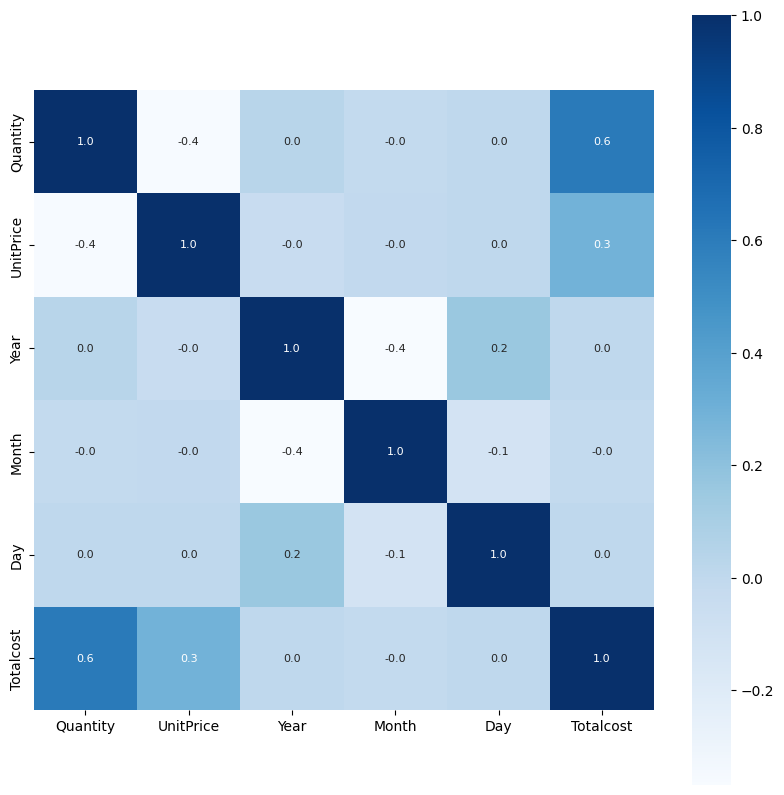

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,annot_kws={'size':8},fmt='.1f',cmap='Blues',cbar=True,square=True)

# Visualizations and Analysis

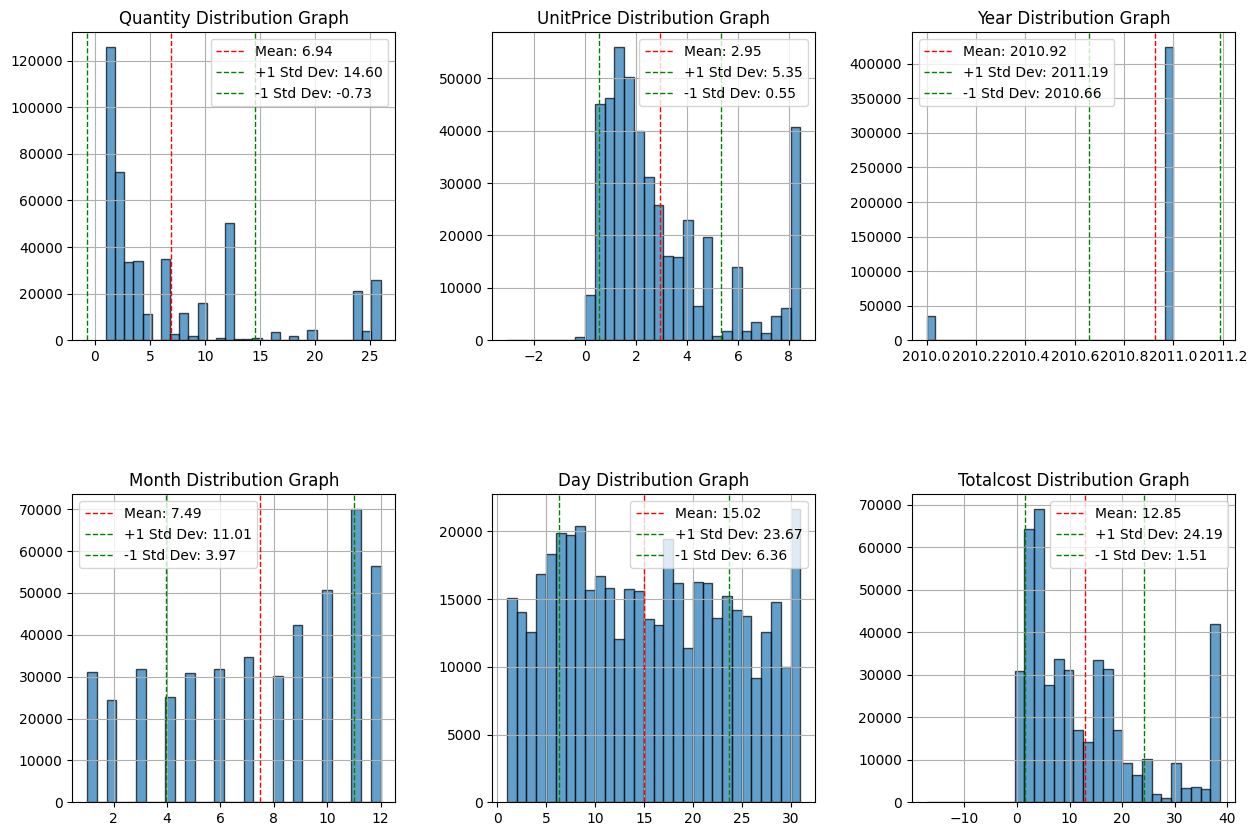

In [19]:
num_cols=df.select_dtypes('number').columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i+1)
    plt.hist(df[col], edgecolor="black", alpha=0.7, bins=30)
    
    mean = df[col].mean()
    std_dev = df[col].std()
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='g', linestyle='dashed', linewidth=1, label=f'+1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='g', linestyle='dashed', linewidth=1, label=f'-1 Std Dev: {mean - std_dev:.2f}')
    
    plt.title(f"{col} Distribution Graph")
    plt.legend()
    plt.grid(True)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

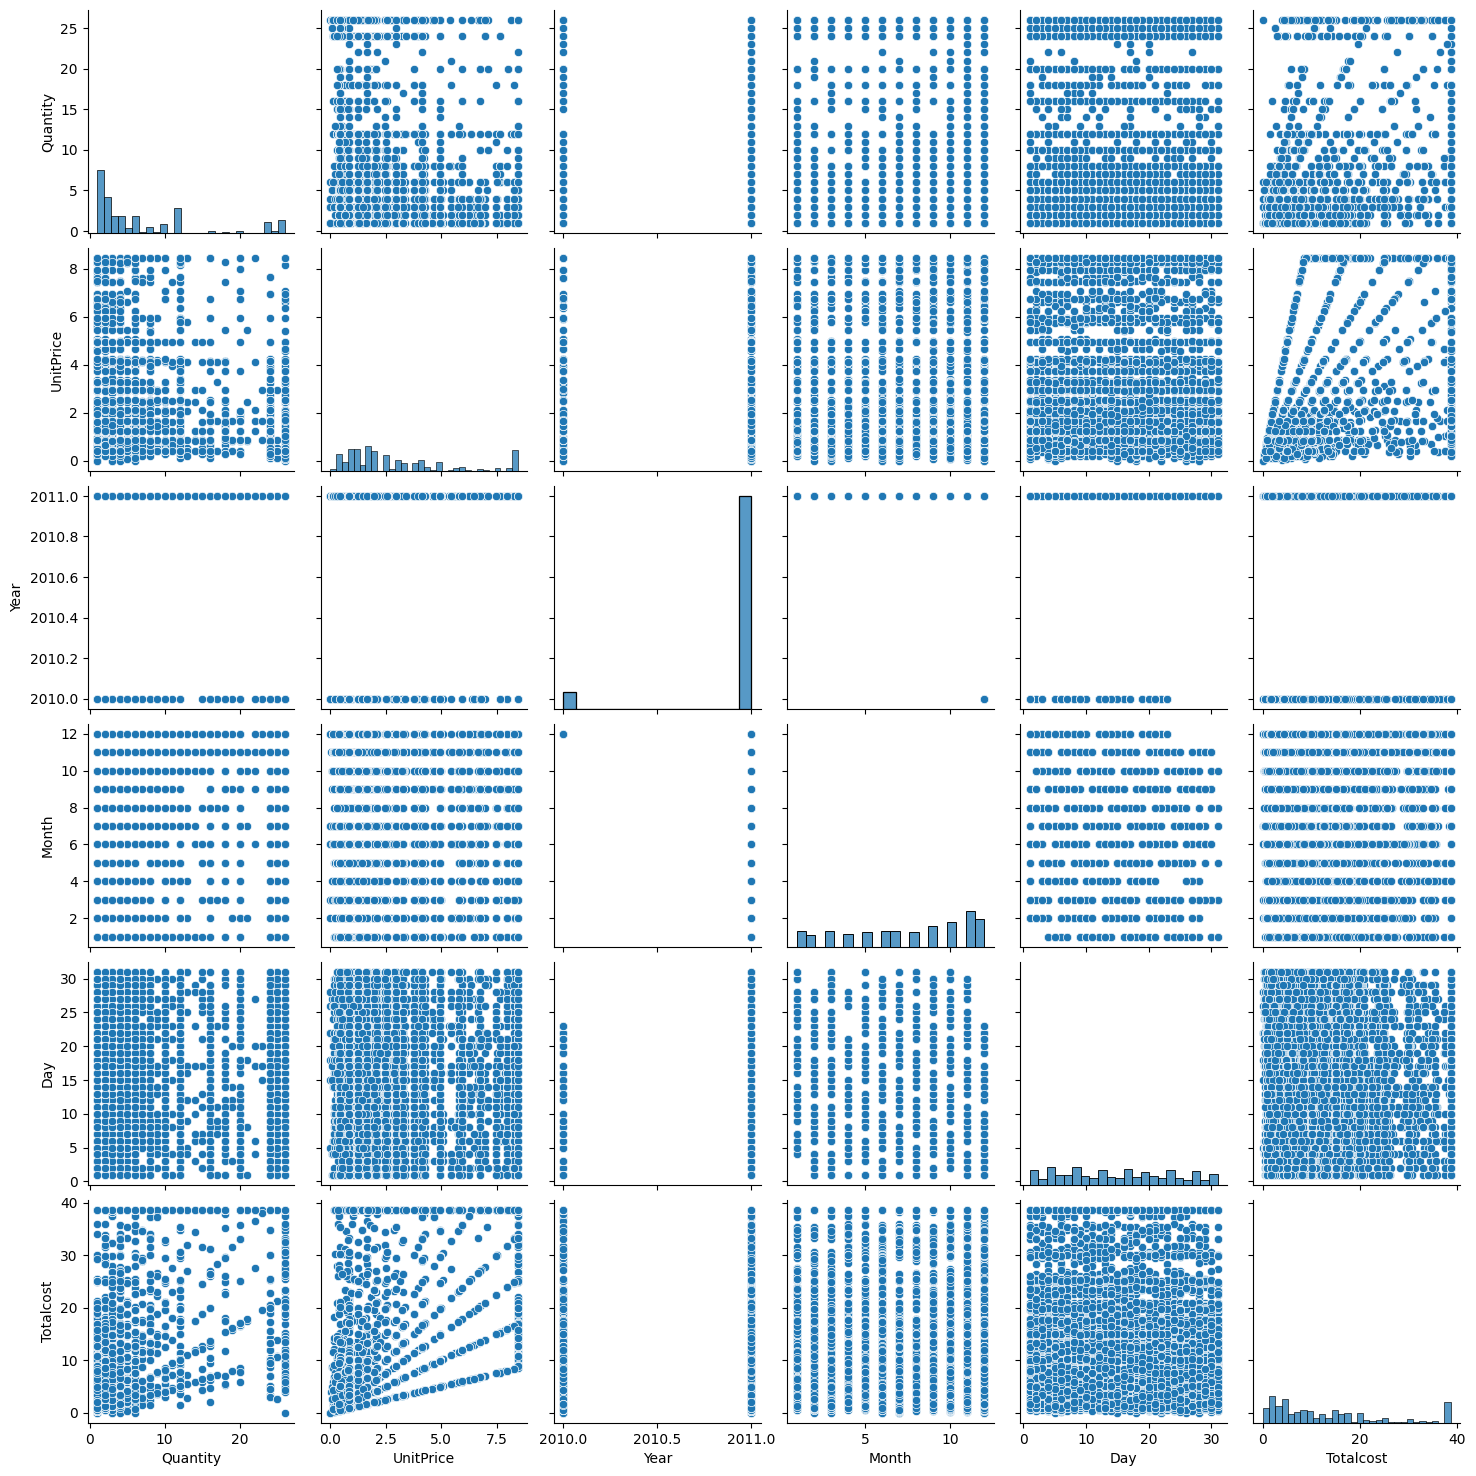

In [20]:
sns.pairplot(df.sample(10000))
plt.show()

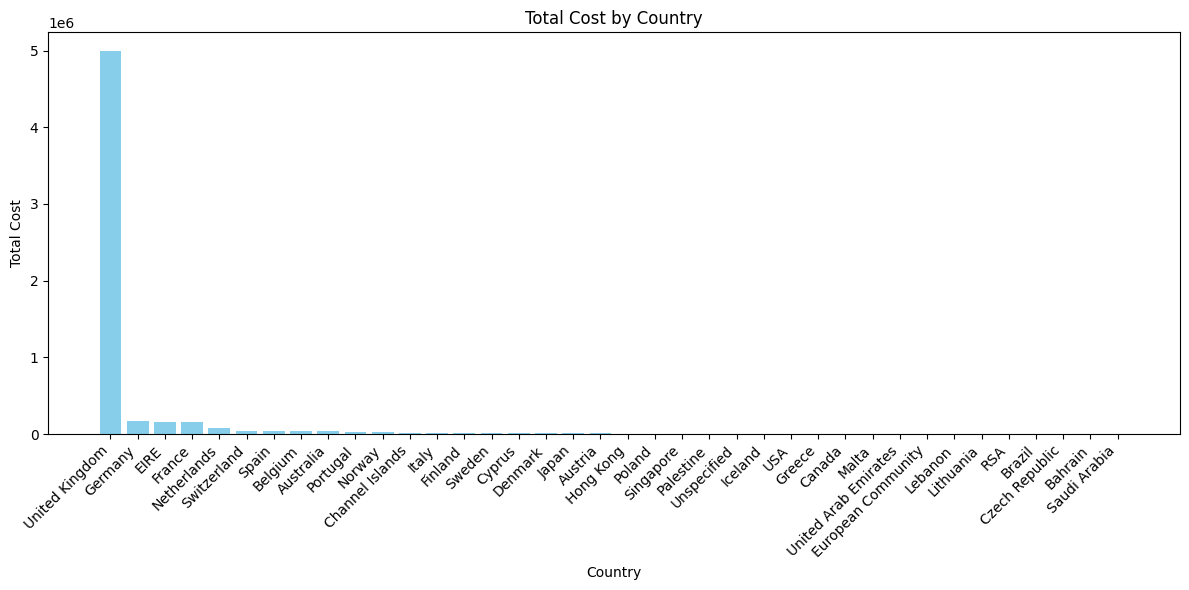

In [21]:
country_cost = df.groupby('Country')['Totalcost'].sum().reset_index()
country_cost = country_cost.sort_values(by='Totalcost', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(country_cost['Country'], country_cost['Totalcost'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Total Cost')
plt.title('Total Cost by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

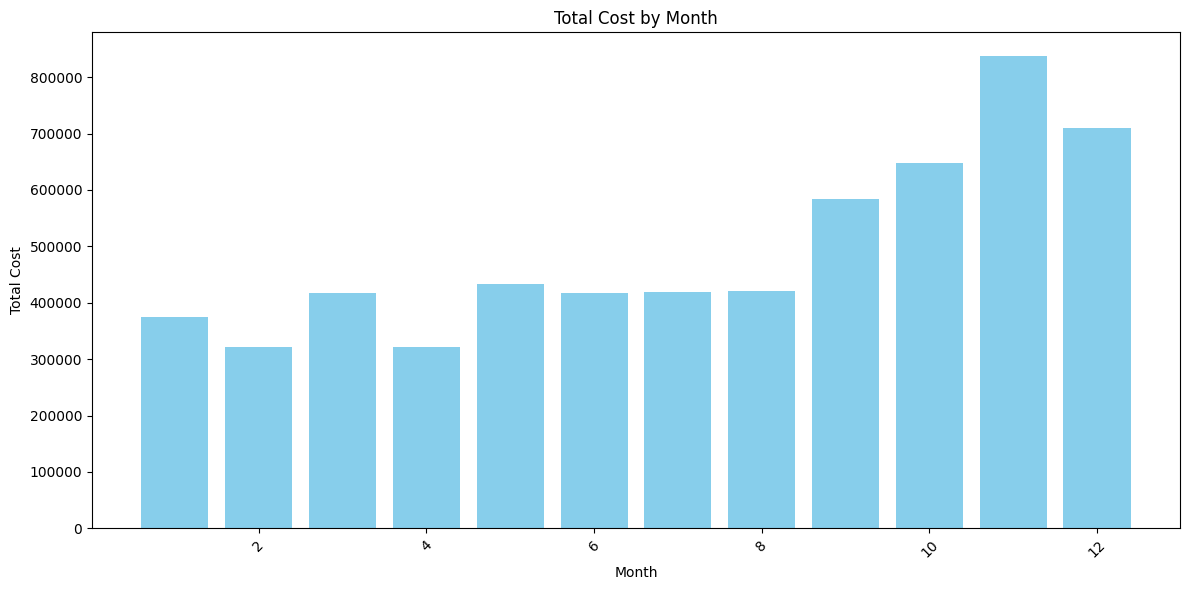

In [22]:
month_cost = df.groupby('Month')['Totalcost'].sum().reset_index()
month_cost = month_cost.sort_values(by='Month')

plt.figure(figsize=(12, 6))
plt.bar(month_cost['Month'], month_cost['Totalcost'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.title('Total Cost by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

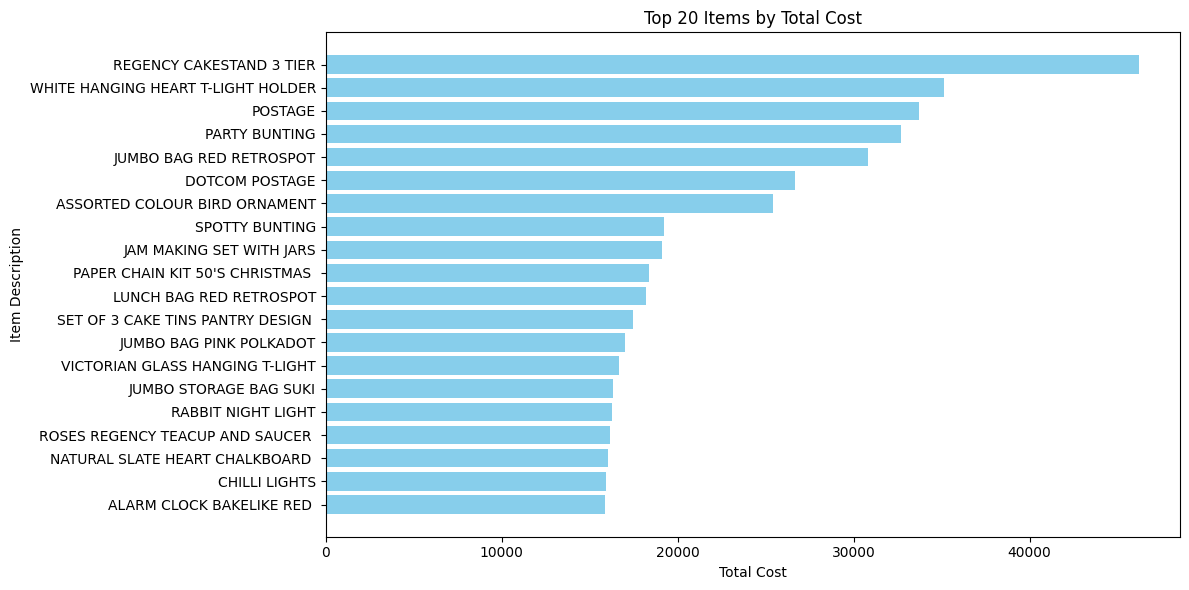

In [23]:
item_cost = df.groupby('Description')['Totalcost'].sum().reset_index()
top_items = item_cost.sort_values(by='Totalcost', ascending=False).head(20)


plt.figure(figsize=(12, 6))
plt.barh(top_items['Description'], top_items['Totalcost'], color='skyblue')
plt.xlabel('Total Cost')
plt.ylabel('Item Description')
plt.title('Top 20 Items by Total Cost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Encoding And Scaling

In [24]:
obj_cols = df.select_dtypes('object').columns
obj_cols
for col in obj_cols:
    df[col] = df[col].astype(str)

# Encoding categorical variables
label_encoder = LabelEncoder()
for col in obj_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Feature scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[obj_cols] = scaler.fit_transform(df[obj_cols])
df

,Description,Quantity,UnitPrice,Country,Year,Month,Day,Totalcost
0,1.563211,-0.122509,-0.165850,0.298306,-3.471756,1.280556,-1.619567,0.216134
1,1.570250,-0.122509,0.183919,0.298306,-3.471756,1.280556,-1.619567,0.660582
2,-1.047629,0.138430,-0.082572,0.298306,-3.471756,1.280556,-1.619567,0.806968
3,-0.187029,-0.122509,0.183919,0.298306,-3.471756,1.280556,-1.619567,0.660582
4,0.685891,-0.122509,0.183919,0.298306,-3.471756,1.280556,-1.619567,0.660582
...,...,...,...,...,...,...,...,...
531280,0.221272,0.660308,-0.873717,-3.200717,0.288039,1.280556,-0.695319,-0.233605
531281,-1.197222,-0.122509,-0.353227,-3.200717,0.288039,1.280556,-0.695319,-0.021963
531282,-1.191943,-0.383448,0.500377,-3.200717,0.288039,1.280556,-0.695319,0.330774
531283,-1.192822,-0.383448,0.500377,-3.200717,0.288039,1.280556,-0.695319,0.330774


# Modeling

### 1- K-Means

In [25]:
pca=PCA(n_components=2)
df=pca.fit_transform(df)
df = pd.DataFrame(df, columns=['PCA_Component_1', 'PCA_Component_2'])
df_pca=df.sample(100000)

In [27]:
inertia_values = []
silhouette_values = []

for i in range(2, 11):
    kmeans =MiniBatchKMeans(n_clusters=i,batch_size=1000)
    kmeans.fit(df_pca)
    
    inertia_values.append(kmeans.inertia_)
    
    # Calculate silhouette score
    score = silhouette_score(df_pca, kmeans.labels_)
    silhouette_values.append(score)
    print(f'{i} cluster has a score is {score}')

2 cluster has a score is 0.454558504943271
3 cluster has a score is 0.5234675738605808
4 cluster has a score is 0.4164128455352666
5 cluster has a score is 0.40524675970441315
6 cluster has a score is 0.4030391209691538
7 cluster has a score is 0.4108423423471242
8 cluster has a score is 0.4063748212329913
9 cluster has a score is 0.38245456412021367
10 cluster has a score is 0.3908358862280369


In [ ]:
# Inertia Plot
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Silhouette Score Plot
plt.plot(range(2, 11), silhouette_values, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()